# IEmodel

## Filter molecular descriptor

In [ ]:
# Load required libraries
library(readxl)
library(dplyr)
library(writexl)
library(caret)
library(e1071)
library(randomForest)
library(xgboost)


# Load the initial data
data <- read.csv('model_data.csv')

# Feature selection: Remove descriptors with the same value for >95% of compounds
threshold <- 0.95 * nrow(data)

check_identical <- function(x) {
  if (is.numeric(x)) {
    sum(x == x[1], na.rm = TRUE) <= threshold
  } else if (is.character(x) || is.factor(x)) {
    sum(as.character(x) == as.character(x[1]), na.rm = TRUE) <= threshold
  } else {
    TRUE  # Keep columns of other types
  }
}

# Ensure we keep 'Name' and 'LogRIE'
cols_to_keep <- sapply(data, check_identical)
cols_to_keep['Name'] <- TRUE
cols_to_keep['LogRIE'] <- TRUE

reduced_data <- data[, cols_to_keep]

# Feature selection: Remove descriptors with pairwise R^2 higher than 0.8
numeric_cols <- sapply(reduced_data, is.numeric)
correlation_matrix <- cor(reduced_data[, numeric_cols & !(names(reduced_data) %in% c('Name', 'LogRIE'))])
mask <- abs(correlation_matrix) > sqrt(0.8)
to_drop_correlation <- colnames(mask)[colSums(mask) > 1]
final_data <- reduced_data[, !(names(reduced_data) %in% to_drop_correlation)]

# Separate the features and target variable
X_final <- final_data[, !(names(final_data) %in% c('Name', 'LogRIE'))]
y_final <- final_data$LogRIE


# Print dimensions to verify
cat("Dimensions of X_final:", dim(X_final), "\n")

Dimensions of X_final: 1213 72 

Length of y_final: 1213 

In [ ]:
# Split the data into training and testing sets
set.seed(42)
train_indices <- createDataPartition(y_final, p = 0.8, list = FALSE)
X_train_final <- X_final[train_indices, ]
X_test_final <- X_final[-train_indices, ]
y_train_final <- y_final[train_indices]
y_test_final <- y_final[-train_indices]


# Scale the data
scaler_final <- preProcess(X_train_final, method = c("center", "scale"))
X_train_scaled_final <- predict(scaler_final, X_train_final)
X_test_scaled_final <- predict(scaler_final, X_test_final)


# Train and evaluate the SVM model
svm_final <- svm(x = X_train_scaled_final, y = y_train_final, kernel = "radial", cost = 10, gamma = 0.001)
y_pred_svm_final <- predict(svm_final, X_test_scaled_final)
mse_svm_final <- mean((y_test_final - y_pred_svm_final)^2)
r2_svm_final <- 1 - sum((y_test_final - y_pred_svm_final)^2) / sum((y_test_final - mean(y_test_final))^2)
cat("SVM: MSE =", mse_svm_final, ", R^2 =", r2_svm_final, "\n")

SVM: MSE = 0.009707875 , R^2 = 0.9632628 

# For SVM model

# Training set performance

In [ ]:
y_pred_svm_train <- predict(svm_final, X_train_scaled_final)
mse_svm_train <- mean((y_train_final - y_pred_svm_train)^2)
r2_svm_train <- 1 - sum((y_train_final - y_pred_svm_train)^2) / sum((y_train_final - mean(y_train_final))^2)

# Test set performance (you've already calculated this, but I'm including it for completeness)
y_pred_svm_test <- predict(svm_final, X_test_scaled_final)
mse_svm_test <- mean((y_test_final - y_pred_svm_test)^2)
r2_svm_test <- 1 - sum((y_test_final - y_pred_svm_test)^2) / sum((y_test_final - mean(y_test_final))^2)

# Print results
cat("SVM Training: MSE =", mse_svm_train, ", R^2 =", r2_svm_train, "\n")

SVM Training: MSE = 0.00676369 , R^2 = 0.9731805 

SVM Test:     MSE = 0.009707875 , R^2 = 0.9632628 

# Set up cross-validation

In [ ]:
ctrl <- trainControl(method = "cv", number = 10)  # 5-fold cross-validation

# Train the model using cross-validation
svm_cv <- train(x = X_train_scaled_final, y = y_train_final, 
                method = "svmRadial", 
                trControl = ctrl,
                tuneGrid = data.frame(C = 10, sigma = 0.001))

# Print cross-validation results
print(svm_cv)

Support Vector Machines with Radial Basis Function Kernel 

972 samples
 72 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 875, 875, 875, 875, 876, 875, ... 
Resampling results:

  RMSE        Rsquared   MAE       
  0.08353802  0.9671732  0.04251171

Tuning parameter 'sigma' was held constant at a value of 0.001
Tuning
 parameter 'C' was held constant at a value of 10

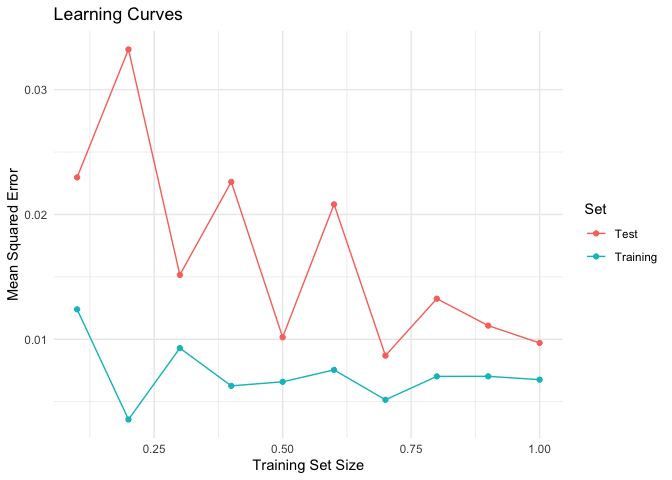

In [ ]:
# Function to calculate MSE
calculate_mse <- function(model, X, y) {
  predictions <- predict(model, X)
  mean((y - predictions)^2)
}

# Create learning curves
train_sizes <- seq(0.1, 1, by = 0.1)
train_errors <- numeric(length(train_sizes))
test_errors <- numeric(length(train_sizes))

for (i in seq_along(train_sizes)) {
  size <- floor(train_sizes[i] * nrow(X_train_scaled_final))
  indices <- sample(1:nrow(X_train_scaled_final), size)
  
  X_train_subset <- X_train_scaled_final[indices, ]
  y_train_subset <- y_train_final[indices]
  
  model <- svm(x = X_train_subset, y = y_train_subset, kernel = "radial", cost = 10, gamma = 0.001)
  
  train_errors[i] <- calculate_mse(model, X_train_subset, y_train_subset)
  test_errors[i] <- calculate_mse(model, X_test_scaled_final, y_test_final)
}

# Plot learning curves
df <- data.frame(
  TrainingSize = rep(train_sizes, 2),
  Error = c(train_errors, test_errors),
  Set = rep(c("Training", "Test"), each = length(train_sizes))
)

ggplot(df, aes(x = TrainingSize, y = Error, color = Set)) +
  geom_line() +
  geom_point() +
  theme_minimal() +
  labs(title = "Learning Curves", x = "Training Set Size", y = "Mean Squared Error")

# Train and evaluate the Random Forest model

In [ ]:
rf_optimized <- randomForest(x = X_train_scaled_final, y = y_train_final, ntree = 50, nodesize = 2, maxnodes = 2^10, seed = 42)
y_pred_rf_optimized <- predict(rf_optimized, X_test_scaled_final)
mse_rf_optimized <- mean((y_test_final - y_pred_rf_optimized)^2)
r2_rf_optimized <- 1 - sum((y_test_final - y_pred_rf_optimized)^2) / sum((y_test_final - mean(y_test_final))^2)
cat("Random Forest: MSE =", mse_rf_optimized, ", R^2 =", r2_rf_optimized, "\n")

Random Forest: MSE = 0.01547962 , R^2 = 0.9414209 

# Train and evaluate the XGBoost model

In [ ]:
set.seed(42)
dtrain <- xgb.DMatrix(data = as.matrix(X_train_scaled_final), label = y_train_final)
dtest <- xgb.DMatrix(data = as.matrix(X_test_scaled_final))
params <- list(objective = "reg:squarederror", seed = 42)
xg_reg <- xgb.train(params = params, data = dtrain, nrounds = 100)
y_pred_xg <- predict(xg_reg, dtest)
mse_xg <- mean((y_test_final - y_pred_xg)^2)
r2_xg <- 1 - sum((y_test_final - y_pred_xg)^2) / sum((y_test_final - mean(y_test_final))^2)
cat("XGBoost: MSE =", mse_xg, ", R^2 =", r2_xg, "\n")

XGBoost: MSE = 0.01657133 , R^2 = 0.9372896 